# 01-beam-correction.ipynb

In [1]:
import imageio.v3 as iio
import matplotlib.pyplot as plt
import napari
import numpy as np
from pathlib import Path
from skimage import exposure, filters, util
# Local imports
import helpers

In [2]:
# Open napari window
viewer = napari.Viewer()

Note: You may need to put an "r" before the image directory path if the string contains backslashes. Don't forget commas between parameters!

In [3]:
img_dir = Path(
        r'X:\Radiography Drive\2013-11_APS'
        r'\Clarke_2013_November\048_Sn27Bi_100')
img_start = 352
img_stop = 372
img_step = 1
imgs = helpers.get_imgs(
    img_dir,
    img_start=img_start,
    img_stop=img_stop,
    img_step=img_step,
    # n_imgs=20,
    print_nums=True
)

Loading 20 images...
Images loaded:
['0: 352', '1: 353', '2: 354', '3: 355', '4: 356', '5: 357', '6: 358', '7: 359', '8: 360', '9: 361', '10: 362', '11: 363', '12: 364', '13: 365', '14: 366', '15: 367', '16: 368', '17: 369', '18: 370', '19: 371']


In [4]:
viewer.add_image(imgs, name=f'imgs-{img_start}-{img_stop}-{img_step}')

<Image layer 'imgs-352-372-1' at 0x28569c1c430>

In [5]:
beam_img_dir = Path(
        r"X:\Radiography Drive\2013-11_APS"
        r"\Clarke_2013_November\036_MonoBeam")
beam_imgs = [
        iio.imread(path) for path in beam_img_dir.glob('*.tif')
        if 'AVG' not in path.stem]
print(len(beam_imgs))
beam_imgs = np.stack(beam_imgs)
print(f'{beam_imgs.shape=}')

105
beam_imgs.shape=(105, 1024, 1280)


In [6]:
print(f'{beam_imgs[0].dtype=}')
print(f'{beam_imgs[0].shape=}')
print(f'{beam_imgs[0].min()=}')
print(f'{beam_imgs[0].max()=}')

beam_imgs[0].dtype=dtype('uint16')
beam_imgs[0].shape=(1024, 1280)
beam_imgs[0].min()=442
beam_imgs[0].max()=4095


In [7]:
print(f'{beam_imgs.shape=}')
print(f'{beam_imgs.dtype=}')
avg_beam_img = np.mean(beam_imgs, axis=0)
avg_beam_img = exposure.rescale_intensity(
        avg_beam_img, in_range=np.uint16, out_range=float)
# avg_beam_img = util.img_as_uint(avg_beam_img)
# avg_beam_img = avg_beam_img.astype(np.uint16)
print(f'{avg_beam_img.shape=}')
print(f'{avg_beam_img.dtype=}')
print(f'{avg_beam_img.min()=}')
print(f'{avg_beam_img.max()=}')

beam_imgs.shape=(105, 1024, 1280)
beam_imgs.dtype=dtype('uint16')
avg_beam_img.shape=(1024, 1280)
avg_beam_img.dtype=dtype('float64')
avg_beam_img.min()=0.00711448262833019
avg_beam_img.max()=0.06248569466697185


In [8]:
viewer.add_image(avg_beam_img, name='avg uint16')

<Image layer 'avg uint16' at 0x2856b2eff70>

In [9]:
print(f'{avg_beam_img.dtype=}')
# Normalize data by white beam (image of beam without sample)
imgs_beam_norm = imgs - (avg_beam_img / imgs)
print(f'{imgs_beam_norm.dtype=}')
viewer.add_image(imgs_beam_norm, name='beam-norm imgs')

avg_beam_img.dtype=dtype('float64')
imgs_beam_norm.dtype=dtype('float64')


<Image layer 'beam-norm imgs' at 0x28569c056d0>

In [10]:
# Subtract liquid image from raw data
imgs_liq_sub = imgs - imgs[0, :, :]
print(f'{imgs_liq_sub.dtype=}')
viewer.add_image(imgs_liq_sub, name='imgs - liq')

imgs_liq_sub.dtype=dtype('uint16')


<Image layer 'imgs - liq' at 0x28569bf7df0>

In [11]:
# Subtract liquid image from normalized data
imgs_beam_norm_liq_sub = imgs_beam_norm - imgs_beam_norm[0, :, :]
print(f'{imgs_beam_norm_liq_sub.dtype=}')
viewer.add_image(imgs_beam_norm_liq_sub, name='beam_norm - liq')

imgs_beam_norm_liq_sub.dtype=dtype('float64')


<Image layer 'beam_norm - liq' at 0x28563407c70>

In [12]:
# Subtract liquid image from data (float)
imgs_float = util.img_as_float(imgs)
imgs_float_liq_sub = imgs_float - imgs_float[0, :, :]
print(f'{imgs_float_liq_sub.dtype=}')
print(f'{imgs_float_liq_sub.min()=}')
print(f'{imgs_float_liq_sub.max()=}')
viewer.add_image(imgs_liq_sub, name='imgs_float - liq')

imgs_float_liq_sub.dtype=dtype('float64')
imgs_float_liq_sub.min()=-0.014908064393072403
imgs_float_liq_sub.max()=0.021484702830548562


<Image layer 'imgs_float - liq' at 0x285634077c0>

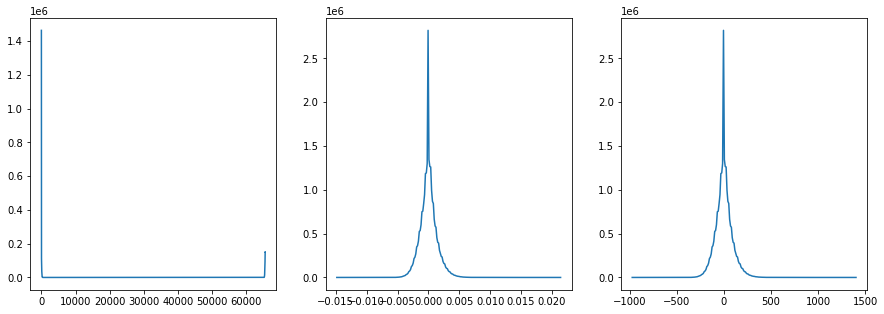

In [13]:
vals_sub, bins_sub = exposure.histogram(imgs_liq_sub)
vals_float_sub, bins_float_sub = exposure.histogram(imgs_float_liq_sub)
vals_beam_norm_sub, bins_beam_norm_sub = exposure.histogram(
        imgs_beam_norm_liq_sub)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
ax = axes.ravel()
ax[0].plot(bins_sub, vals_sub)
ax[1].plot(bins_float_sub, vals_float_sub)
ax[2].plot(bins_beam_norm_sub, vals_beam_norm_sub)
plt.show()

In [ ]:
imgs_sub_uint16_conv = util.img_as_uint(imgs_float_liq_sub)
viewer.add_image(imgs_sub_uint16_conv, name='converted to uint16')
vals_sub_uint16_conv, bins_sub_uint16_conv = exposure.histogram(
        imgs_sub_uint16_conv)
imgs_sub_uint16_resc = exposure.rescale_intensity(
        imgs_float_liq_sub, in_range='image', out_range='uint16')
viewer.add_image(imgs_sub_uint16_resc, name='rescaled to uint16')
vals_sub_uint16_resc, bins_sub_uint16_resc = exposure.histogram(
        imgs_sub_uint16_resc)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
ax = axes.ravel()
ax[0].plot(bins_float_sub, vals_float_sub)
ax[1].plot(bins_sub_uint16_conv, vals_sub_uint16_conv)
ax[2].plot(bins_sub_uint16_resc, vals_sub_uint16_resc)
plt.show()

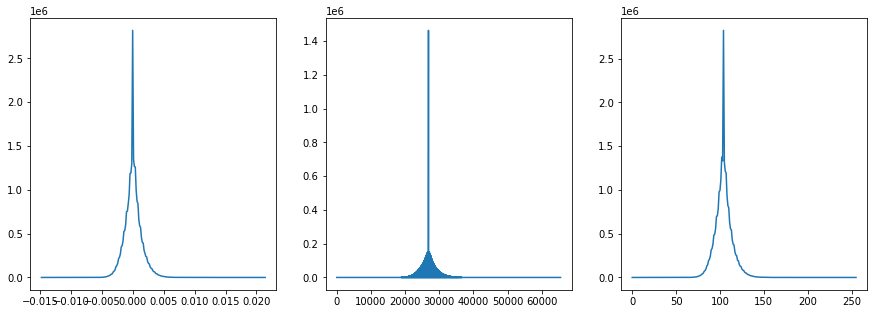

In [19]:
imgs_sub_uint8_resc = exposure.rescale_intensity(
        imgs_float_liq_sub, in_range='image', out_range='uint8')
viewer.add_image(imgs_sub_uint8_resc, name='rescaled to uint8')
vals_sub_uint8_resc, bins_sub_uint8_resc = exposure.histogram(
        imgs_sub_uint8_resc)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
ax = axes.ravel()
ax[0].plot(bins_float_sub, vals_float_sub)
ax[1].plot(bins_sub_uint16_resc, vals_sub_uint16_resc)
ax[2].plot(bins_sub_uint8_resc, vals_sub_uint8_resc)
plt.show()

In [25]:
def save_as_pngs(save_dir, imgs):
    save_dir = Path(save_dir)
    if not save_dir.is_dir():
        save_dir.mkdir()
    else:
        raise ValueError(f'Directory already exists: {save_dir}')
    exp_name = save_dir.stem
    n_imgs = imgs.shape[0]
    n_digits = len(str(n_imgs))
    for i in range(n_imgs):
        iio.imwrite(
                Path(save_dir) / f'{exp_name}_{str(i).zfill(n_digits)}.png',
                imgs[i, :, :])

In [26]:
save_dir = Path(
        r'C:\Users\gusb\Research\aps-directional'
        r'\results\048_Sn27Bi_100-352-372-1_liq-sub')
save_as_pngs(save_dir, imgs_sub_uint8_resc)

In [ ]:
helpers.save_as_gif(
    (
        f'results/{img_dir.stem}-{img_start}-{img_stop}-{img_step}'
        f'_beam-norm_liq-sub.gif'
    ),
    imgs_sub_uint_resc,
    equalize_hist=False,
    fps=5
)